# Behavioral Cloning for Self-Driving Car Simulation

This notebook demonstrates an end-to-end deep learning pipeline for behavioral cloning using the Udacity self-driving car simulator. The goal is to train a neural network to predict steering angles from camera images, mimicking human driving behavior.


**Pipeline Overview:**
- Data loading and exploration
- Data balancing
- Data augmentation
- Image preprocessing
- Model architecture (NVIDIA model)
- Training and evaluation
- Saving the trained model


> **Note:** This notebook uses Keras, TensorFlow, OpenCV, and imgaug. Make sure your environment has GPU support for faster training.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Conv2D
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

2025-09-04 18:08:15.283881: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Environment Check: GPU Availability

Deep learning model training is much faster on a GPU compared to a CPU. The following cell checks if TensorFlow can detect a GPU on your system. If the output is 0, your code will run on CPU only, which may be significantly slower.

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Data Loading and Exploration

The dataset consists of images and a CSV log file (`driving_log.csv`) generated by the Udacity self-driving car simulator. The CSV contains paths to center, left, and right camera images, as well as steering angles and other driving parameters. In this section, we load the CSV and display the first few rows to understand the data structure.

In [3]:
DIRECTORY = '../data/'
LOG_CSV = 'driving_log.csv'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(DIRECTORY, LOG_CSV), names=columns)
pd.set_option('display.max_colwidth', None)
print(data.head())

                                                                                      center  \
0  /home/boy/Desktop/self-driving-car-simulation/data/IMG/center_2025_09_04_01_48_01_167.jpg   
1  /home/boy/Desktop/self-driving-car-simulation/data/IMG/center_2025_09_04_01_48_01_277.jpg   
2  /home/boy/Desktop/self-driving-car-simulation/data/IMG/center_2025_09_04_01_48_01_386.jpg   
3  /home/boy/Desktop/self-driving-car-simulation/data/IMG/center_2025_09_04_01_48_01_491.jpg   
4  /home/boy/Desktop/self-driving-car-simulation/data/IMG/center_2025_09_04_01_48_01_595.jpg   

                                                                                       left  \
0   /home/boy/Desktop/self-driving-car-simulation/data/IMG/left_2025_09_04_01_48_01_167.jpg   
1   /home/boy/Desktop/self-driving-car-simulation/data/IMG/left_2025_09_04_01_48_01_277.jpg   
2   /home/boy/Desktop/self-driving-car-simulation/data/IMG/left_2025_09_04_01_48_01_386.jpg   
3   /home/boy/Desktop/self-driving-car-simu

### Extracting Image Filenames

The image paths in the CSV may include full directory information. For easier file access, we extract just the filename from each path for the center, left, and right images.

In [4]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
print(data.head())

                               center                              left  \
0  center_2025_09_04_01_48_01_167.jpg  left_2025_09_04_01_48_01_167.jpg   
1  center_2025_09_04_01_48_01_277.jpg  left_2025_09_04_01_48_01_277.jpg   
2  center_2025_09_04_01_48_01_386.jpg  left_2025_09_04_01_48_01_386.jpg   
3  center_2025_09_04_01_48_01_491.jpg  left_2025_09_04_01_48_01_491.jpg   
4  center_2025_09_04_01_48_01_595.jpg  left_2025_09_04_01_48_01_595.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2025_09_04_01_48_01_167.jpg       0.0       0.0      0.0  0.000151  
1  right_2025_09_04_01_48_01_277.jpg       0.0       0.0      0.0  0.000151  
2  right_2025_09_04_01_48_01_386.jpg       0.0       0.0      0.0  0.000151  
3  right_2025_09_04_01_48_01_491.jpg       0.0       0.0      0.0  0.000150  
4  right_2025_09_04_01_48_01_595.jpg       0.0       0.0      0.0  0.000151  


### Visualizing Steering Angle Distribution

To understand the balance of the dataset, we plot a histogram of the steering angles. This helps identify if the data is biased toward straight driving or contains enough turning examples.

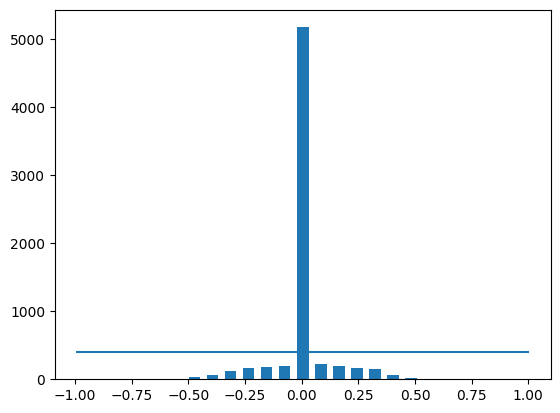

In [5]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
plt.show()

### Dataset Size

Print the total number of data points and the shape of the dataframe to get an overview of the dataset size before and after balancing.

In [6]:
print('Total data: ', len(data))
print(data.shape)

Total data:  6804
(6804, 7)


### Data Balancing

The dataset is often imbalanced, with many more examples of straight driving than turning. To prevent the model from being biased toward driving straight, we limit the number of samples per steering angle bin. This step randomly removes excess samples from overrepresented bins.

In [7]:
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

print('Removed Images: ', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('Remaining Images: ', len(data))
print(data.shape)

Removed Images:  4774
Remaining Images:  2030
(2030, 7)


### Post-Balancing Distribution

After balancing, we plot the histogram again to verify that the steering angle distribution is more uniform.

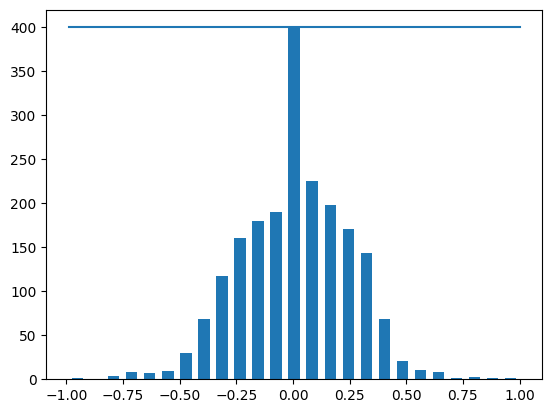

In [8]:
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
plt.show()

## Image Loading and Steering Angle Correction

Each row in the CSV provides paths to center, left, and right camera images. To increase data diversity, we use all three images per row. For left and right images, we apply a correction factor to the steering angle to simulate recovery from the sides of the lane.

In [9]:
def load_image_steering(datadir, df):
    images = []
    steering = []
    for i in range(len(df)):
        indexed_data = df.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        steering_center = float(indexed_data[3])
        correction = 0.15
        steering_left = steering_center + correction
        steering_right = steering_center - correction
        img_center = mpimg.imread(os.path.join(datadir, center))
        img_left = mpimg.imread(os.path.join(datadir, left))
        img_right = mpimg.imread(os.path.join(datadir, right))
        images.extend([img_center, img_left, img_right])
        steering.extend([steering_center, steering_left, steering_right])
    images = np.array(images)
    steering = np.array(steering)
    return images, steering

### Train/Validation Split

We split the dataset into training and validation sets. The training set is used to fit the model, while the validation set is used to evaluate performance and detect overfitting.

In [10]:
images, steering = load_image_steering(DIRECTORY + 'IMG/', data)
print(images.shape, steering.shape)
X_train, X_valid, y_train, y_valid = train_test_split(images, steering, test_size=0.2, random_state=6)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

/tmp/ipykernel_61821/735406899.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
/tmp/ipykernel_61821/735406899.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering_center = float(indexed_data[3])


(6090, 160, 320, 3) (6090,)
(4872, 160, 320, 3) (4872,)
(1218, 160, 320, 3) (1218,)


In [11]:
images[0]

array([[[123, 152, 194],
        [123, 152, 194],
        [122, 151, 193],
        ...,
        [ 17,  30,  38],
        [ 22,  35,  41],
        [ 29,  42,  48]],

       [[123, 152, 194],
        [123, 152, 194],
        [123, 152, 194],
        ...,
        [ 12,  25,  33],
        [ 21,  34,  40],
        [ 32,  45,  51]],

       [[124, 153, 195],
        [124, 153, 195],
        [124, 153, 195],
        ...,
        [  2,  17,  24],
        [ 12,  27,  32],
        [ 27,  42,  47]],

       ...,

       [[ 89,  95,  91],
        [102, 108, 104],
        [ 65,  71,  67],
        ...,
        [ 97,  99,  85],
        [110, 112,  98],
        [109, 111,  97]],

       [[109, 115, 111],
        [117, 123, 119],
        [ 88,  94,  90],
        ...,
        [107, 109,  95],
        [134, 136, 122],
        [ 98, 100,  86]],

       [[165, 171, 167],
        [172, 178, 174],
        [ 87,  93,  89],
        ...,
        [113, 115, 101],
        [124, 126, 112],
        [101, 103,  89]]

In [12]:
steering[0]

-0.04468489

### Visualizing Train/Validation Distributions

Plotting the steering angle distributions for both training and validation sets helps ensure that both sets are representative of the overall data and similarly distributed.

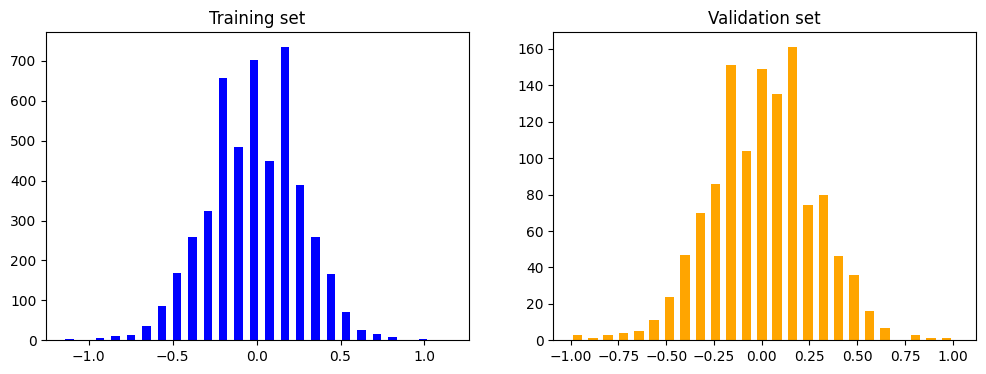

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
ax[0].set_title('Training set')
ax[1].hist(y_valid, bins=num_bins, width=0.05, color='orange')
ax[1].set_title('Validation set')
plt.show()

## Data Augmentation

To improve model generalization and simulate real-world driving conditions, we apply several data augmentation techniques. These include zoom, pan, brightness adjustment, and horizontal flipping. Each augmentation helps the model learn to handle different scenarios.

### Zoom Augmentation
Zooming simulates the effect of the car moving closer to or farther from objects, helping the model become robust to scale changes.

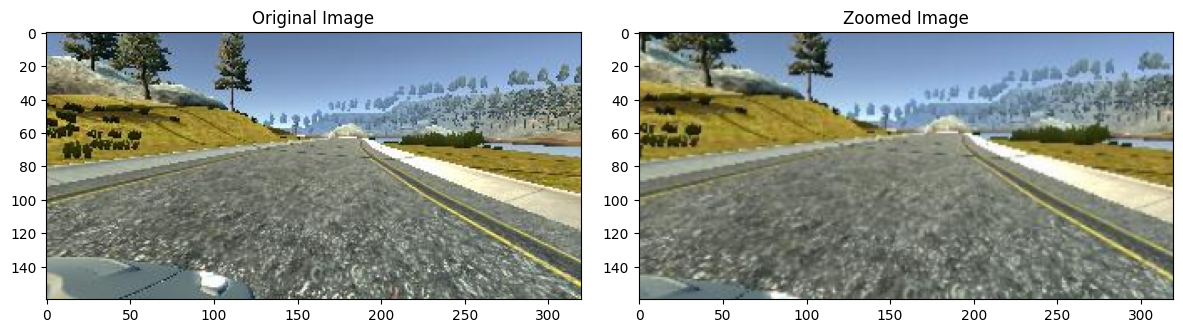

In [14]:
def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image

image = images[random.randint(0, len(images)-1)]
# original = plt.imshow(image)
# zoomed = plt.imshow(zoom(image))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.tight_layout()

ax[0].set_title('Original Image')
ax[0].imshow(image)

ax[1].set_title('Zoomed Image')
ax[1].imshow(zoom(image))
plt.show()

### Pan Augmentation

Panning shifts the image horizontally and vertically, simulating the effect of the car being off-center in the lane. This helps the model learn to recover from slight deviations.

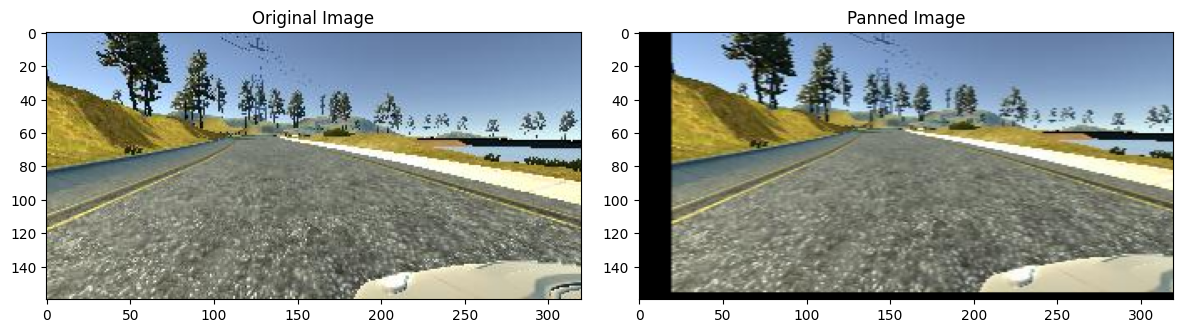

In [15]:
def pan(image):
    pan = iaa.Affine(translate_percent={'x': (-0.1, 0.1), 'y': (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

image = images[random.randint(0, len(images)-1)]
# original = plt.imshow(image)
# panned = plt.imshow(pan(image))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.tight_layout()

ax[0].set_title('Original Image')
ax[0].imshow(image)

ax[1].set_title('Panned Image')
ax[1].imshow(pan(image))
plt.show()

### Brightness Augmentation

Randomly adjusting image brightness simulates different lighting conditions, such as driving at different times of day or in varying weather.

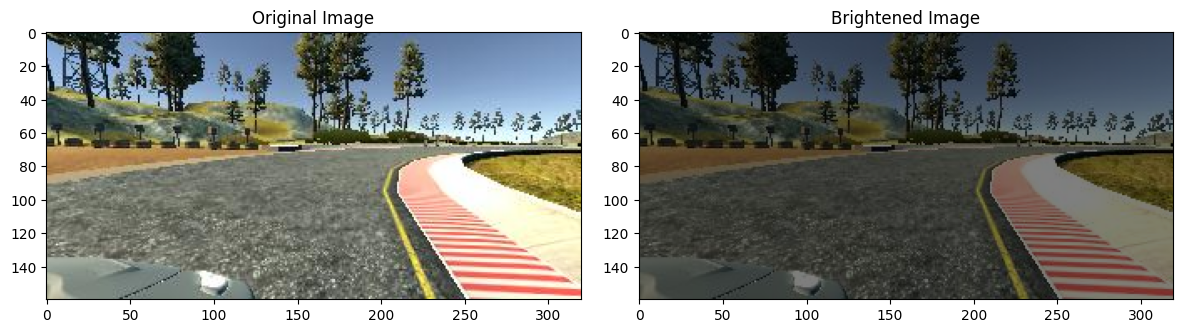

In [16]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

image = images[random.randint(0, len(images)-1)]
# original = plt.imshow(image)
# bright = plt.imshow(img_random_brightness(image))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.tight_layout()

ax[0].set_title('Original Image')
ax[0].imshow(image)

ax[1].set_title('Brightened Image')
ax[1].imshow(img_random_brightness(image))
plt.show()

### Horizontal Flip Augmentation

Randomly flipping images horizontally and inverting the steering angle helps the model learn that left and right turns are symmetric, increasing data diversity.

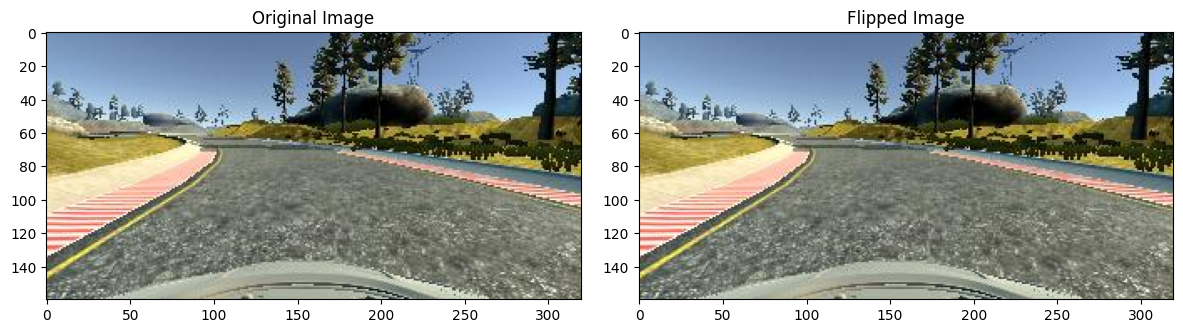

In [17]:
def img_random_flip(image, steering):
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        steering = -steering
    return image, steering

image = images[random.randint(0, len(images)-1)]
steer = steering[random.randint(0, len(steering)-1)]
# original = plt.imshow(image)
flipped, flipped_steer = img_random_flip(image, steer)
# flipped = plt.imshow(flipped)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.tight_layout()

ax[0].set_title('Original Image')
ax[0].imshow(image)

ax[1].set_title('Flipped Image')
ax[1].imshow(flipped)
plt.show()

### Combined Augmentation Function

The `random_augment` function applies a sequence of augmentations (zoom, pan, brightness, flip) to an image and its steering angle. This is used during training to generate diverse data on the fly.

In [18]:
def random_augment(image, steering):
    image = zoom(image)
    image = pan(image)
    image = img_random_brightness(image)
    image, steering = img_random_flip(image, steering)
    return image, steering

### Visualizing Augmented Images

To verify that augmentations are working as intended, we display original and augmented images side by side for several random samples.

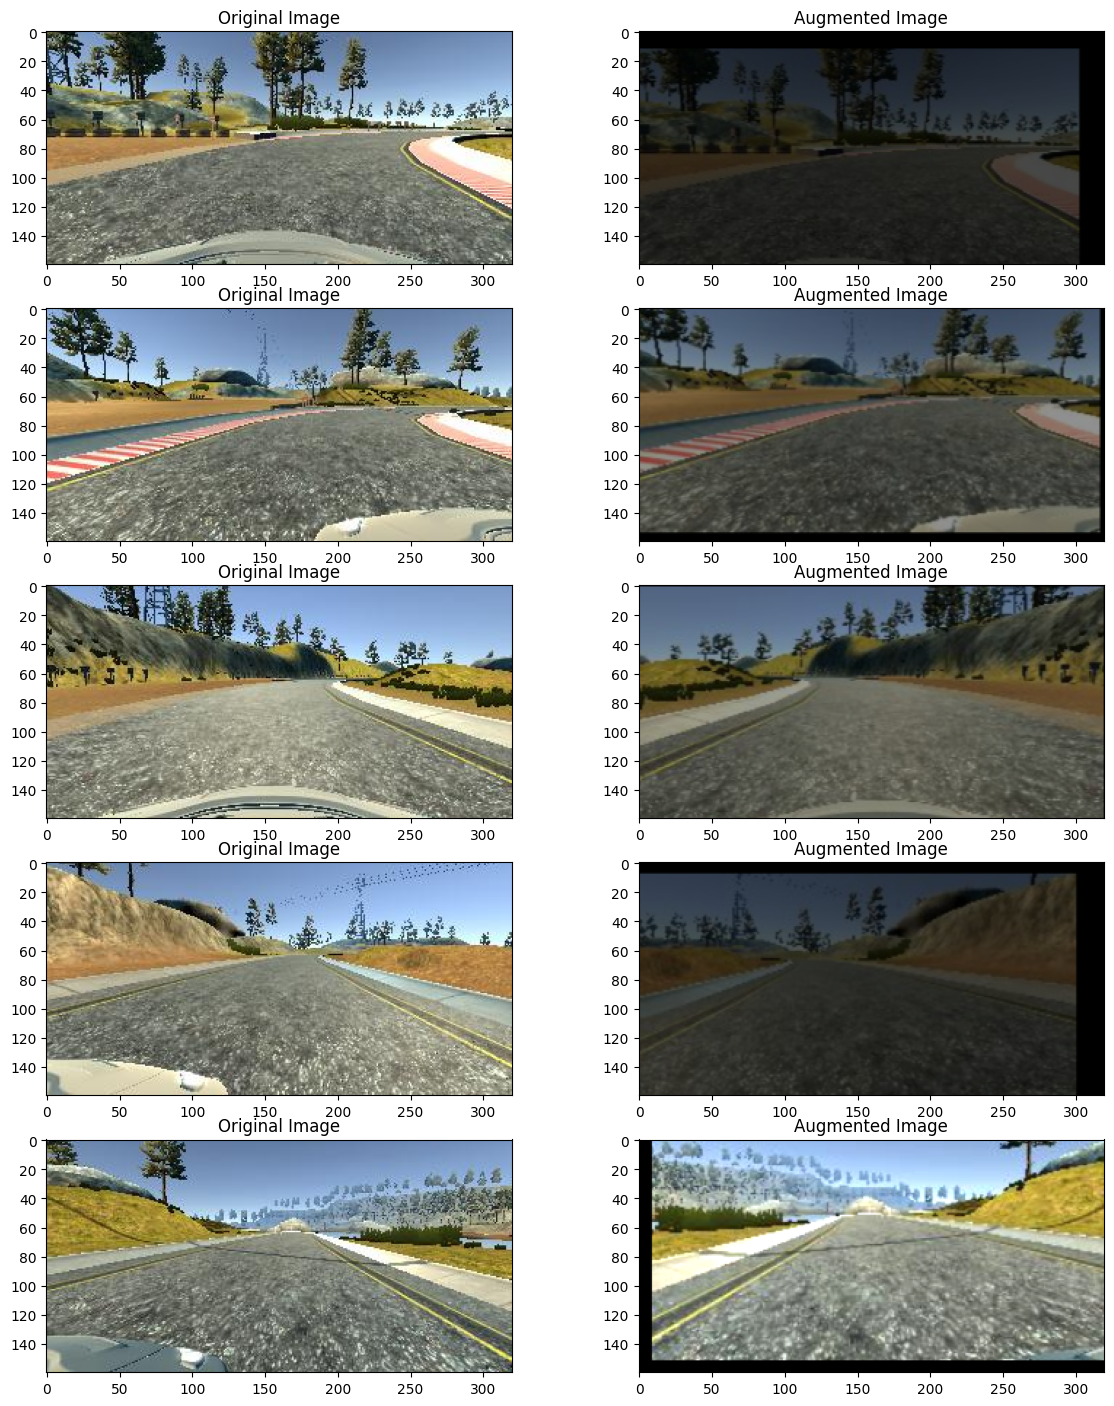

In [19]:
ncol = 2
nrow = 5

fig, ax = plt.subplots(nrow, ncol, figsize=(12, 14))
fig.tight_layout()

for i in range(nrow):
    image = images[random.randint(0, len(images)-1)]
    steer = steering[random.randint(0, len(steering)-1)]
    original = image
    augmented, _ = random_augment(image, steer)

    ax[i, 0].set_title('Original Image')
    ax[i, 0].imshow(original)
    ax[i, 1].set_title('Augmented Image')
    ax[i, 1].imshow(augmented)

plt.show()

## Image Preprocessing

Before feeding images to the model, we preprocess them by cropping, resizing, color space conversion, blurring, and normalization. This reduces irrelevant information (like the sky and car hood), standardizes input size, and improves model performance.

In [20]:
def image_preprocess(img):
    img = img[60:135, :, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img / 255
    return img

### Visualizing Preprocessing

Display an original image and its preprocessed version to verify that cropping, resizing, and normalization are working as intended.

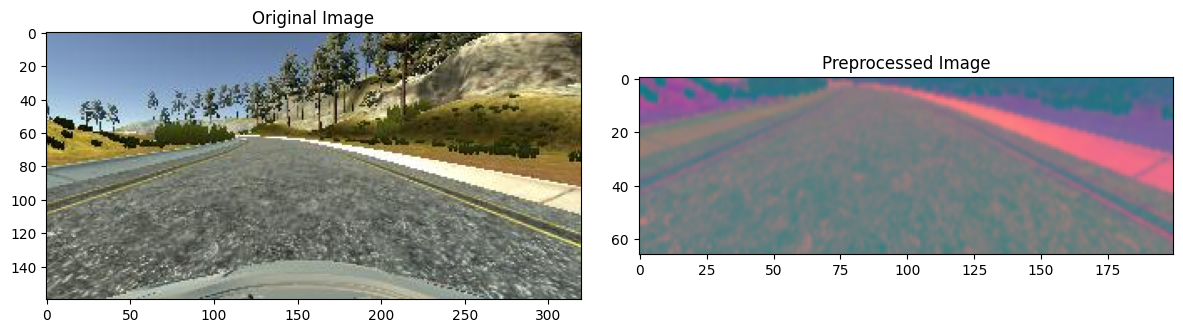

In [21]:
image = images[random.randint(0, len(images)-1)]

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.tight_layout()
ax[0].set_title('Original Image')
ax[0].imshow(image)
ax[1].set_title('Preprocessed Image')
ax[1].imshow(image_preprocess(image))
plt.show()

## Batch Generator for Training

The batch generator yields batches of preprocessed and (optionally) augmented images and steering angles for model training. This allows for efficient memory usage and on-the-fly data augmentation.

In [22]:
def batch_generator(images, steering, batch_size, is_training):
    while True:
        batch_images = []
        batch_steering = []
        for i in range(batch_size):
            random_index = random.randint(0, len(images) - 1)
            if is_training:
                image, steer = random_augment(images[random_index], steering[random_index])
            else:
                image, steer = images[random_index], steering[random_index]
            image = image_preprocess(image)
            batch_images.append(image)
            batch_steering.append(steer)
        yield (np.asarray(batch_images), np.asarray(batch_steering))

x_train_generator, y_train_generator = next(batch_generator(X_train, y_train, 1, 1))
print(x_train_generator.shape, y_train_generator.shape)
x_valid_generator, y_valid_generator = next(batch_generator(X_valid, y_valid, 1, 0))
print(x_valid_generator.shape, y_valid_generator.shape)

(1, 66, 200, 3) (1,)
(1, 66, 200, 3) (1,)


### Visualizing Batch Samples

Display a sample training and validation image from the batch generator to verify that preprocessing and augmentation are working as expected.

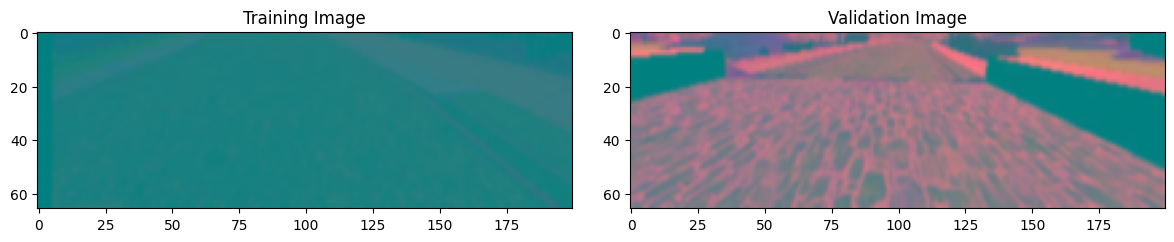

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.tight_layout()

ax[0].set_title('Training Image')
ax[0].imshow(x_train_generator[0])
ax[1].set_title('Validation Image')
ax[1].imshow(x_valid_generator[0])
plt.show()

## Model Architecture: NVIDIA End-to-End Network

We use the NVIDIA end-to-end convolutional neural network architecture, which has been proven effective for self-driving car behavioral cloning. The model consists of several convolutional layers followed by fully connected layers, and is designed to process preprocessed images and output a steering angle.

In [24]:
def nvidia_model():
    model = Sequential()
    model.add(Conv2D(24, (5, 5), strides=(2, 2), activation='elu', input_shape=(66, 200, 3)))
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(64, (3, 3), activation='elu'))
    model.add(Conv2D(64, (3, 3), activation='elu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1))
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    return model

model = nvidia_model()
model.summary()

/home/boy/miniconda3/envs/car/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1757034598.360737   61821 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5934 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 31, 98, 24)     │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 47, 36)     │        21,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 22, 48)      │        43,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 20, 64)      │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 18, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 18, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       115,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252,219 (985.23 KB)

 Trainable params: 252,219 (985.23 KB)

 Non-trainable params: 0 (0.00 B)

### Model Parameter Count

Print the total number of trainable parameters in the model. This gives an idea of the model's capacity and complexity.

In [25]:
total_params = model.count_params()
print("Total parameters:", total_params)

Total parameters: 252219


## Model Training

We train the model using the batch generator for both training and validation data. The model is trained for a set number of epochs, and validation loss is monitored to detect overfitting. Training time is also recorded.

In [26]:
import time
start = time.time()
history = model.fit(batch_generator(X_train, y_train, 100, 1),
                    steps_per_epoch=300,
                    epochs=10,
                    validation_data=batch_generator(X_valid, y_valid, 100, 0),
                    validation_steps=200,
                    verbose=1,
                    shuffle=1)
end = time.time()
print("Training time:", end - start)

Epoch 1/10


2025-09-04 18:10:22.799349: I external/local_xla/xla/service/service.cc:163] XLA service 0x3d4de3d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-04 18:10:22.799375: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2025-09-04 18:10:22.851142: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-04 18:10:23.085138: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91300
2025-09-04 18:10:23.626100: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[100,64,3,20]{3,2,1,0}, u8[0]{0}) custom-call(f32[100,48,5,22]{3,2,1,0}, f32[64,48,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__c

  1/300 ━━━━━━━━━━━━━━━━━━━━ 23:07 5s/step - loss: 0.2618

I0000 00:00:1757034626.346608   62906 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 ━━━━━━━━━━━━━━━━━━━━ 76s 237ms/step - loss: 0.1215 - val_loss: 0.0462
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 70s 234ms/step - loss: 0.0581 - val_loss: 0.0452
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 69s 230ms/step - loss: 0.0560 - val_loss: 0.0431
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 68s 227ms/step - loss: 0.0520 - val_loss: 0.0394
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 70s 234ms/step - loss: 0.0476 - val_loss: 0.0346
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 66s 219ms/step - loss: 0.0444 - val_loss: 0.0374
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 67s 223ms/step - loss: 0.0421 - val_loss: 0.0323
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 66s 221ms/step - loss: 0.0404 - val_loss: 0.0330
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 66s 222ms/step - loss: 0.0387 - val_loss: 0.0307
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 63s 211ms/step - loss: 0.0378 - val_loss: 0.0330
Training time: 680.6097853183746


### Training and Validation Loss Curves

Plotting the training and validation loss over epochs helps visualize model learning and detect overfitting or underfitting.

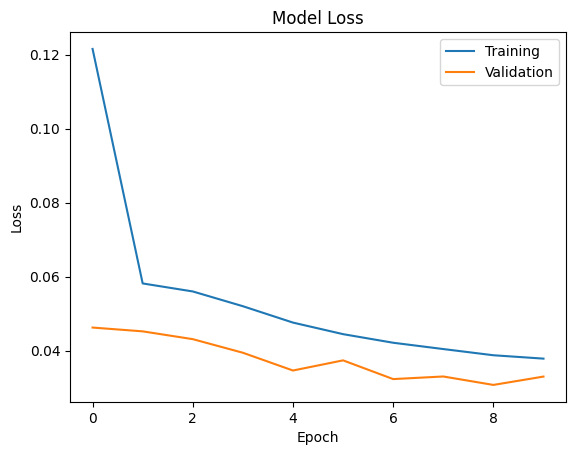

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

### Final Loss Values

Print the final training and validation loss values to summarize model performance at the end of training.

In [28]:
print("Final training loss:", history.history['loss'][-1])
print("Final validation loss:", history.history['val_loss'][-1])

Final training loss: 0.037835922092199326
Final validation loss: 0.032986726611852646


### Best Epoch

Identify the epoch with the lowest validation loss. This is useful for model selection and reporting the best observed performance.

In [29]:
best_epoch = np.argmin(history.history['val_loss'])
print("Best epoch:", best_epoch + 1)
print("Best validation loss:", np.min(history.history['val_loss']))

Best epoch: 9
Best validation loss: 0.030732329934835434


### Example Prediction

Make a prediction on a preprocessed validation sample and compare it to the ground truth steering angle. This demonstrates how to use the trained model for inference.

In [31]:
sample = X_valid[0:1]
sample_preprocessed = np.array([image_preprocess(sample[0])])
prediction = model.predict(sample_preprocessed)
print("Example prediction:", prediction)
print("Ground truth:", y_valid[0])

2025-09-04 18:28:39.061882: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[1,64,3,20]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,48,5,22]{3,2,1,0}, f32[64,48,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-09-04 18:28:39.108068: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[1,64,1,18]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,3,20]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward",

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
Example prediction: [[-0.30611497]]
Ground truth: -0.41358680000000003


## Saving the Trained Model

After training, we save the model to disk for later use in inference or deployment. The model is saved in HDF5 format, and we also print the file size for reference.

In [32]:
import os
model.save(os.path.join('..', 'model', 'model.h5'))
print("Model saved successfully.")
print("Model file size (MB):", os.path.getsize(os.path.join('..', 'model', 'model.h5')) / 1e6)

Model saved successfully.
Model file size (MB): 3.101696
